# A simple data science workflow for processed metabolomics data

In this second notebook, we will be using R to do some basic data analysis tasks for our processed data, including batch correction, QC filtering, normalization, univariate analysis, and pathway analysis.

## Notebook setup

The R runtime environment in Google Colab includes several commonly used packages pre-installed. However, for data science and bioinformatic tasks, we will need to install some additional packages for specific tasks.

R packages generally come from two major sources:

- **CRAN**: Repository for general-purpose R packages
- **Bioconductor**: Bioinformatics-focused repository

Be aware that installing packages in Colab can take several minutes, as many dependencies need to be fetched and compiled. It can take around 10 minutes depending on your connection.

In [1]:
# 1 - setup

install.packages("tune")

library(tidyverse)
library(httr)
library(jsonlite)
library(readr)
library(RColorBrewer)
library(tune)

if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install("sva")

library(sva)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘shape’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘prodlim’, ‘warp’, ‘DiceDesign’, ‘sfd’, ‘future.apply’, ‘globals’, ‘iterators’, ‘listenv’, ‘parallelly’, ‘lhs’, ‘sparsevctrs’, ‘clock’, ‘gower’, ‘ipred’, ‘timeDate’, ‘furrr’, ‘slider’, ‘modelenv’, ‘dials’, ‘doFuture’, ‘foreach’, ‘future’, ‘GPfit’, ‘hardhat’, ‘parsnip’, ‘recipes’, ‘rsample’, ‘workflows’, ‘yardstick’


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conf

### Data download

Next, let's download the three files we need to do the analysis. These are typical outputs from preprocessing pipelines such as XCMS, MS-DIAL, and pcpfm (asari).

1.   **Feature table** -  A dataframe with samples in columns and feature intensities in rows.

2.   **Metadata table** - A dataframe with sample metadata in columns.

3.   **Annotation table** - A dataframe with feature annotations in columns.

The dataset we are using consists of plasma samples analyzed using HILIC positive ion mode (HILIC-Pos) and includes:

- **Qstds (Quality standard samples):** Used to assess instrument performance and consistency over time.
- **A blank sample:** Used to identify background noise and contamination.
- **A DDA sample:** Collected for MS/MS fragmentation for metabolite identification.

A fake batch label was added to simulate batch correction workflows. It was generated by dividing the run order into chunks, mimicking how samples may be processed across different days in real life.

In [2]:
# 2 - data download

# use the GitHub API to read in required csv files
api_url = "https://api.github.com/repos/shuzhao-li-lab/2025_DataScience/contents/data"

# use REST to get contents
res <- GET(api_url)
stop_for_status(res)
files <- content(res, "parsed")

# filter the list to just the csv files
csv_files <- Filter(function(x) grepl("\\.csv$", x$name), files)

# get raw GitHub URLs
csv_urls <- sapply(csv_files, function(x) x[["download_url"]])

# download and read each CSV into a single list
csv_list <- lapply(csv_urls, read.csv)
names(csv_list) <- sapply(csv_files, function(x) gsub(".csv", "", x[["name"]]))

# view an overview of the list structure
dplyr::glimpse(csv_list)

List of 3
 $ hilic_pos_annotations_df:'data.frame':	9883 obs. of  29 variables:
  ..$ id                          : chr [1:9883] "F10000" "F10001" "F10008" "F10013" ...
  ..$ mz                          : num [1:9883] 130 208 130 172 172 ...
  ..$ rtime                       : num [1:9883] 228 139 220 20 149 ...
  ..$ peak_area                   : num [1:9883] 9.85e+08 8.02e+08 9.83e+08 1.13e+06 3.24e+08 ...
  ..$ detection_counts            : int [1:9883] 45 1272 1614 1 159 8 118 1373 382 1655 ...
  ..$ isotope                     : chr [1:9883] "M0" "M0" "M0" "M0" ...
  ..$ modification                : chr [1:9883] "M+H+" "K/H" "M+H+" "K/H" ...
  ..$ ion_relation                : chr [1:9883] "M0,M+H+" "M0,K/H" "M0,M+H+" "M0,K/H" ...
  ..$ parent_epd_id               : chr [1:9883] "kp1068_129.0796" "kp464_169.0509" "kp1069_129.0903" "kp1214_133.0528" ...
  ..$ has_stable_isotope          : int [1:9883] 1 1 1 1 1 1 1 1 1 1 ...
  ..$ has_M0                      : int [1:9883] 1 1 1 1

Now that the data has been downloaded from the GitHub repo and read, let's format it so we can work with it properly. In this case we will:

1 - transpose the feature table so samples are in rows and features in columns;

2 - filter and arrange the data so the same samples appear in the same order in both tables;

3 - remove the blank sample as it was used during the preprocessing step, and will not be useful for statistical analysis.

In [3]:
# 3 - data formatting

# set up metadata file
meta_data <- csv_list$hilic_pos_metadata

# set up feature table
# do not include first column since it's feature ids
feat_tbl_t <- t(csv_list$hilic_pos_ft_tbl_clean[,-1])
colnames(feat_tbl_t) <- csv_list$hilic_pos_ft_tbl_clean %>% pull(X)

# MT_20210726_010 and MT_20210726_011 are excluded through pcpfm pipeline
# there's more samples in metadata than feature table
# let's make sure they're in the same order too
ft_samples <- rownames(feat_tbl_t)

meta_data <- meta_data %>%
  filter(new_name %in% ft_samples)

# we'll remove the blank from the feature and metadata
blank_inx <- grep("Blank", meta_data$new_name)

meta_data <- meta_data[-blank_inx, ]
feat_tbl_t <- feat_tbl_t[-blank_inx, ]

meta_data[1:5, 1:5]
feat_tbl_t[1:5, 1:5]

,sample_type,file_name,sample_id,batch,comment
,<chr>,<chr>,<chr>,<int>,<int>
1,QC,MT_20210726_001,Qstd_20210726_1_001,1,1
2,QC,MT_20210726_003,Qstd_20210726_1_003,1,1
3,QC,MT_20210726_005,Qstd_20210726_1_005,1,1
4,QC,MT_20210726_007,Qstd_20210726_1_007,2,1
5,QC,MT_20210726_009,Qstd_20210726_1_009,2,1


,F1,F2,F3,F4,F5
raw_batch1_07262021_MT___MT_20210726_001,0,0,0,0,0
raw_batch1_07262021_MT___MT_20210726_003,0,0,0,0,0
raw_batch1_07262021_MT___MT_20210726_005,0,0,0,0,0
raw_batch1_07262021_MT___MT_20210726_007,0,0,0,0,0
raw_batch1_07262021_MT___MT_20210726_009,0,0,0,0,0


### Global visualization

First, we will plot a PCA using the raw intensities for all samples. We are looking for any extreme outliers, or samples clustering by batch that needs correction.

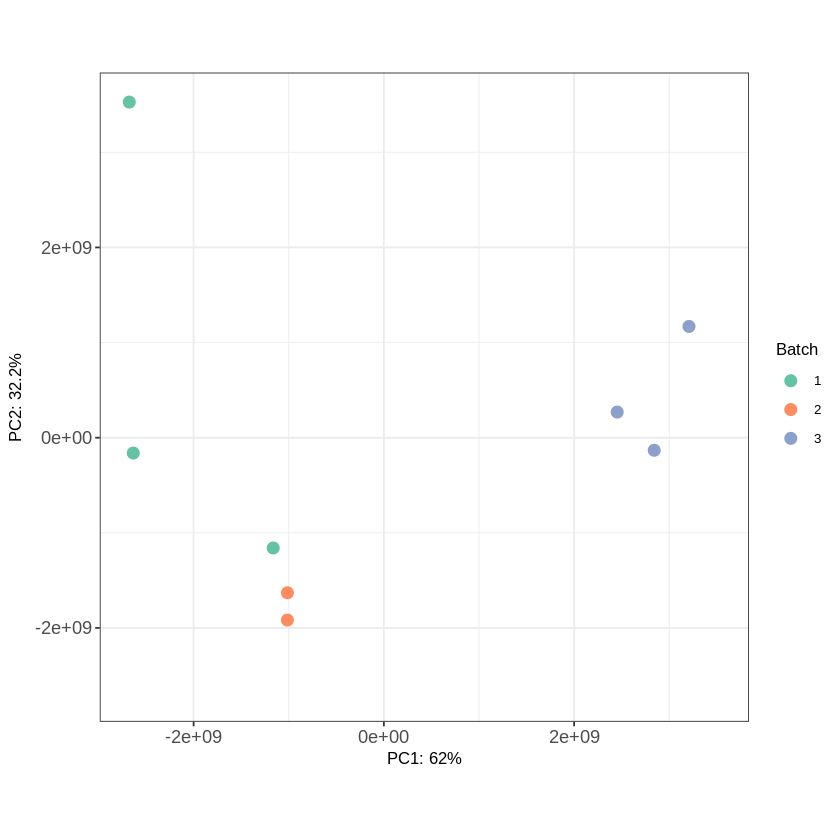

In [4]:
# 4 - PCA
# below is a R function that will be used several times
# it plots a PCA given a feature and metadata table

plot_pca <- function(feat_tbl_t,
                     meta_data){

  # samples in rows
  # features in columns
  pc <- stats::prcomp(na.omit(feat_tbl_t),
                      center = TRUE)

  ### Plot the PCA

  pc$percentVar <- pc$sdev^2/sum(pc$sdev^2)

  pca_res <- as.data.frame(pc$x)
  pca_res$batch <- as.factor(meta_data$batch)

  colors <- setNames(brewer.pal(n = length(levels(pca_res$batch)), name = "Set2"),
                     levels(pca_res$batch))

  p <- ggplot2::ggplot(data = pca_res,
                       ggplot2::aes(x = PC1,
                                    y = PC2,
                                    color = batch)) +
    ggplot2::geom_jitter(size = 3) +
    ggplot2::theme_bw() +
    ggplot2::scale_color_manual(values = colors) +
    ggplot2::labs(x = glue::glue("PC1: ", round(pc$percentVar[1]*100,1), "%"),
                  y = glue::glue("PC2: ", round(pc$percentVar[2]*100,1), "%")) +
    ggplot2::theme(text = ggplot2::element_text(size = 10),
                   axis.text = ggplot2::element_text(size = 11)) +
    ggplot2::guides(color = ggplot2::guide_legend(title = "Batch")) +
    tune::coord_obs_pred()

  return(p)

}

# now plot the raw data
p <- plot_pca(feat_tbl_t, meta_data)

p

In the PCA, samples are colored by their batch label. Samples are clearly clustered by batch. For example, batch 3 samples form a tight cluster that is far from batch 1 and 2 samples. This suggests a batch effect is present, and should be addressed through batch correction.

### Batch correction

We clearly observed clustering by batch in our data, which is not ideal. That indicates the presence of unwanted *technical* variation due to samples being processed in different batches - for example on different days, by different operators, or due to changes in the state of the mass spectrometer (e.g. instrument drift). This can mask true *biological* variation and result in misleading conclusions.

To address this, we will perform batch correction using a commonly used method, **ComBat**. ComBat is an empirical Bayes approach originally developed to remove batch effects in gene expression data from microarray and RNA-seq, and has since been widely adopted in metabolomics workflows. Other batch correction methods (beyond the scope of this tutorial) include EigenMS and WaveICA 2.0.

Found 23478 genes with uniform expression within a single batch (all zeros); these will not be adjusted for batch.


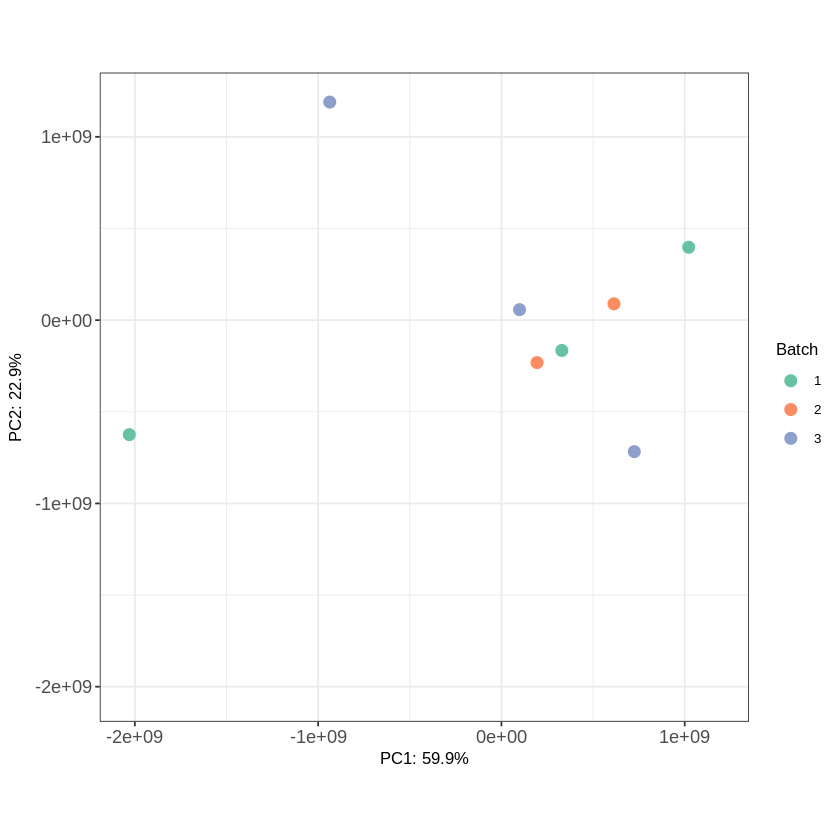

In [5]:
# 5 - performs combat on raw data
batch <- as.factor(meta_data$batch)

combat_data <- suppressMessages(sva::ComBat(dat = t(feat_tbl_t),
                                            batch = batch,
                                            par.prior=TRUE,
                                            prior.plots=FALSE))

# the samples are now intermixed - great!
p_combat <- plot_pca(t(combat_data), meta_data)

p_combat

The code above will output "Found X genes", remember this is because the algorithm was originally intended for gene expression data. Do not worry, genes = metabolic features in this case.  In our case, the batch correction worked well - different batch samples are now well mixed, and we can proceed with our analysis.

### Data processing

After batch correction, we will perform several next steps to ensure high-quality data for downstream analysis:

**1 - Filter features with high variability:** Features with high variation across technical replicates or QC samples are typically unreliable and may reflect noise rather than true biological signal. Removing these features will improve reproducibility and reduce the likelihood of false positives in subsequent data analysis.

**2 - Filter features with missing values:** Features with excessive missing values may results from low abundance metabolites,  inconsistent detection, or technical artifacts. Including all features can compromise statistical power, so we keep just consistently detected features, focusing on robust signals.

**3 - Data normalization:** This final step corrects for unwanted variation in signal intensity due to technical differences. This helps to reduce heteroscedasticity and makes features more comparable across samples. Common normalization methods include auto-scaling, pareto scaling, and log transformation.

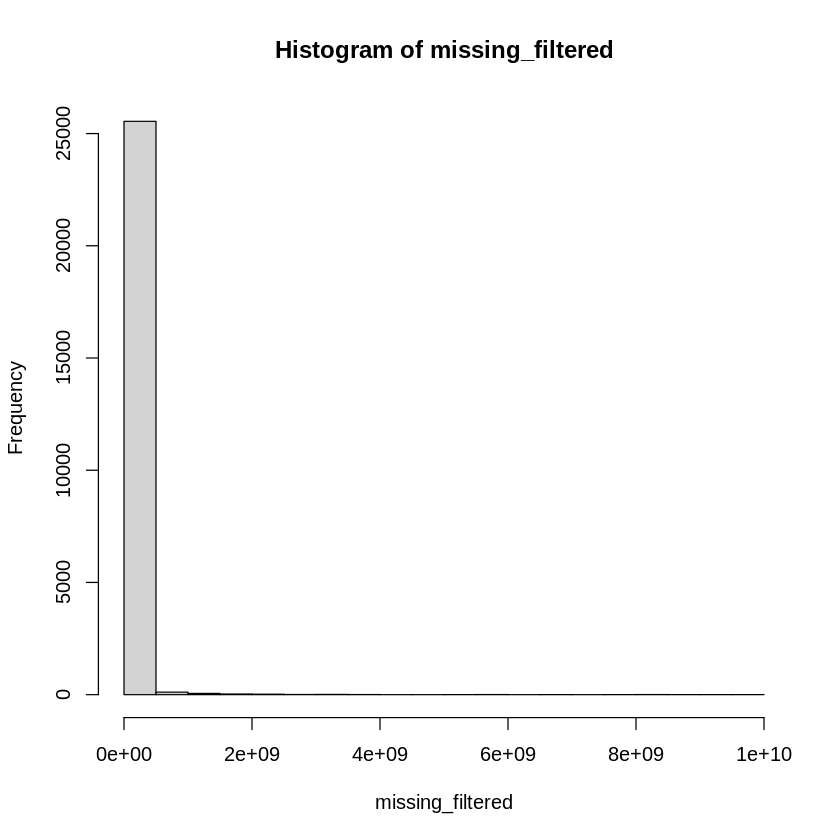

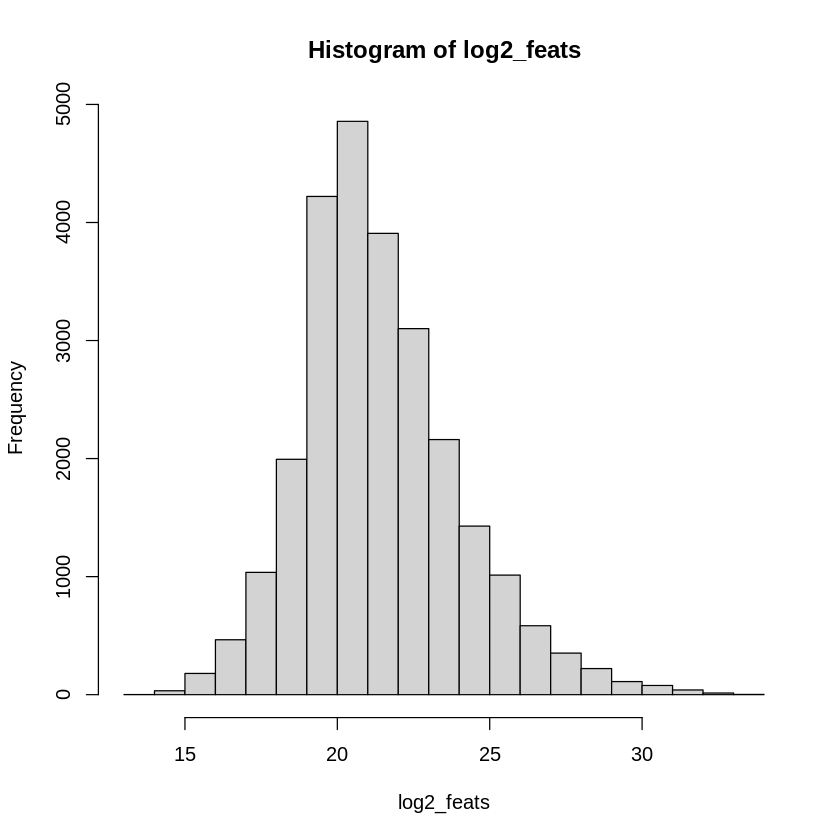

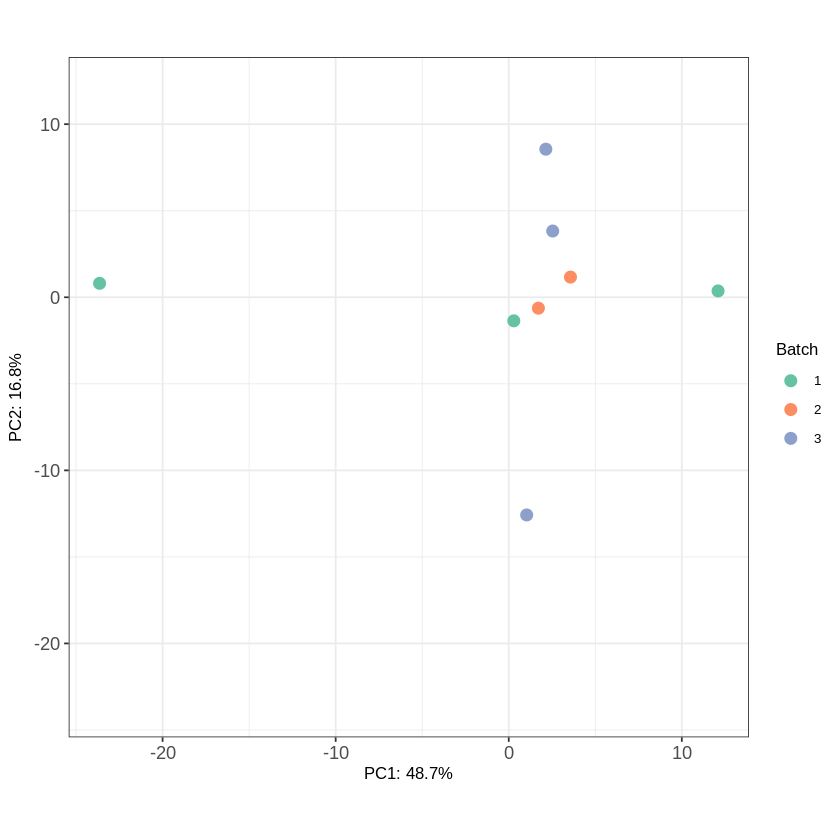

In [6]:
# 6 - data processing

### RSD filtering
# RSD = (Standard Deviation / Mean) × 100
# filter out features with high variability across replicates or QC samples

# compute RSD per feature (row-wise)
rsd <- apply(combat_data, 1, function(x) sd(x, na.rm = TRUE) / mean(x, na.rm = TRUE) * 100)
rsd_thresh <- 30

# filter to keep features with RSD below threshold
rsd_filtered <- combat_data[rsd < rsd_thresh, , drop = FALSE]

### Missing value filtering
# remove features with >= 20% missing values
missing_filtered <- rsd_filtered[rowMeans(is.na(rsd_filtered)) <= 0.2, ]

### normalization
# we see a intense left skew, lets try log2 norm
hist(missing_filtered)

# Log2 normalize with pseudocount to account for NA or 0 values
# distribution of intensities is improved (Gaussian shape)
log2_feats <- log2(missing_filtered + 1)
hist(log2_feats)

final_ft_tbl <- as.data.frame(t(log2_feats))

# cleaned data
# final visualization, looks good! let's move on to stats
p_clean <- plot_pca(final_ft_tbl, meta_data)

p_clean

Our first visual assessment here is the distribution of our data. In the first histogram (of filtered intensity data), we observe a left-skewed distribution, which tells us the data is not normally distributed. This is problematic as many statistical tests assume data normality (e.g. t-tests, ANOVA), and skewed data violates these assumptions and may lead to inaccurate results. To address this, we apply a log2 transformation to the data, and the distribution is visually evaluated again with another histogram. From this plot, we observe a Gaussian-like distribution centered in the middle of the x-axis, suggesting the transformation has successfully normalized the data. Finally, the PCA using the normalized data still shows the samples are intermixed, so we are confident to move onto the statistical analysis.

### Statistical Analysis

Now that the data is ready, we will perform univariate analysis to identify metabolic features that are significantly different across our experimental groups. Each feature will be tested individually to determine whether its intensity varies by group.

In this case, we are using *batch* as the categorical variable, which has three levels, so we will use **Analysis of Variance (ANOVA)**. ANOVA is designed to compare the means of a continuous variable (ie metabolic feature intensity) across more than two groups.

- **Null hypothesis (H0):** All group mean intensities are the same.
- **Alternative hypothesis (H1):** At least one group's mean intensity differs.

Since ANOVA only tells us that there *is* a difference but not *where*, we can follow up with post-hoc pairwise comparisons using Tukey Honestly Significant Difference (Tukey HSD) test to identify specific groups.

In [7]:
# 7 - Statistical Analysis
# Because this is a dataset of QSTDs created for the purposes of this tutorial,
# we will use the batch label as an outcome

# ANOVAs run per metabolite

anova_df <- dplyr::bind_cols(batch = meta_data$batch,
                             final_ft_tbl) %>%
  mutate(batch = factor(batch))

features <- rownames(log2_feats)

aov_models <- lapply(features, function(x) {

  res <- stats::aov(as.formula(paste(x, " ~ batch")), data = anova_df)

} )

aov_pvals <- sapply(aov_models, function(x) unlist(summary(x))["Pr(>F)1"])
aov_pvals_adj <- p.adjust(aov_pvals, "BH")

aov_res <- data.frame(P.value = aov_pvals,
                      Adj.p.value = aov_pvals_adj) %>%
  arrange(P.value)

rownames(aov_res) <- features
head(aov_res)



,P.value,Adj.p.value
,<dbl>,<dbl>
F35,0.001589297,0.9994575
F52,0.001687087,0.9994575
F77,0.001908613,0.9994575
F89,0.002104379,0.9994575
F90,0.002204691,0.9994575
F103,0.005999282,0.9994575


In our case, none of the features are significantly different from each other (adjusted p-value < 0.05). This is not unexpected as all samples are Qstds. However for the sake of the tutorial, let's look at the raw p-values with a cut-off of 0.15. As well, we will assess whether the data follows a normal distribution, which is an assumption of ANOVA. This will be done by generating a Q-Q plot, which helps us to visually assess whether the residuals are normally distributed.

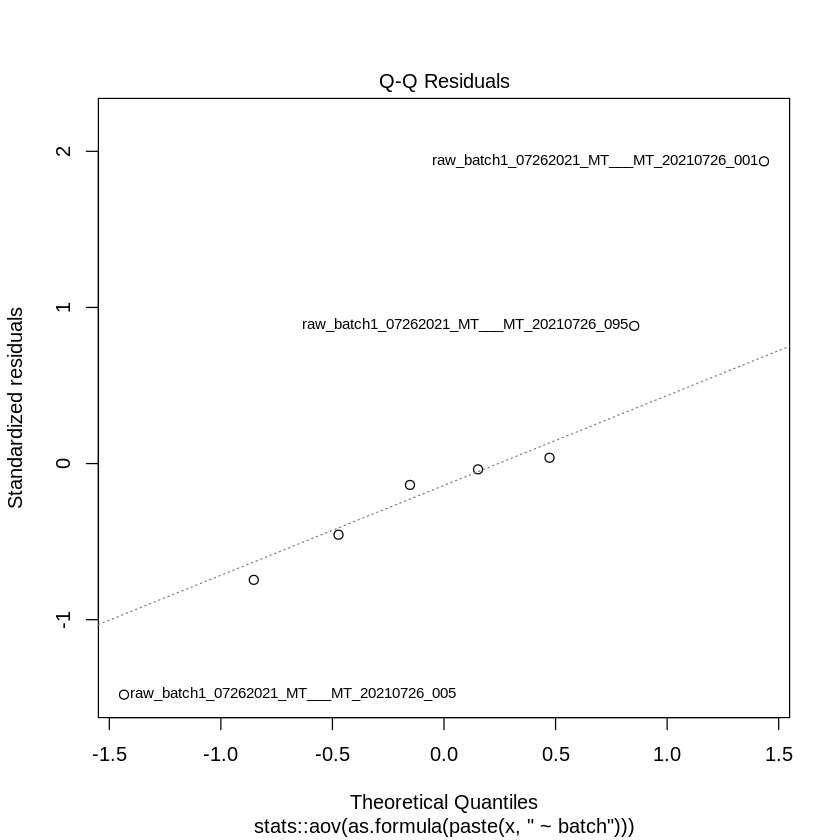

In [8]:
# 8 - QQ plot
# none of the adjusted p-values are significant,
# so let's look at raw p-values
sig_inx <- which(features == "F35")

# check normality assumptions
# with a Q-Q plot
# are residuals normal?
# do points follow the 45' line?
plot(aov_models[[sig_inx]], which = 2)

The Q-Q plot looks good as the points lie close to the reference line, suggesting the data is normally distributed. If we saw a curve, it would mean the data is not normal. To fix this, we would either further transform the data, or use a non-parametric test such as Kruskall-Wallis.

Let us move on to post-hoc comparisons to check  which groups differ significantly in feature intensity.

term,contrast,null.value,estimate,conf.low,conf.high,adj.p.value
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
batch,2-1,0,-0.08821043,-0.7871742,0.6107534,0.9127967
batch,3-1,0,-0.09566050,-0.7208327,0.5295117,0.8754827
batch,3-2,0,-0.00745007,-0.7064139,0.6915137,0.9993371


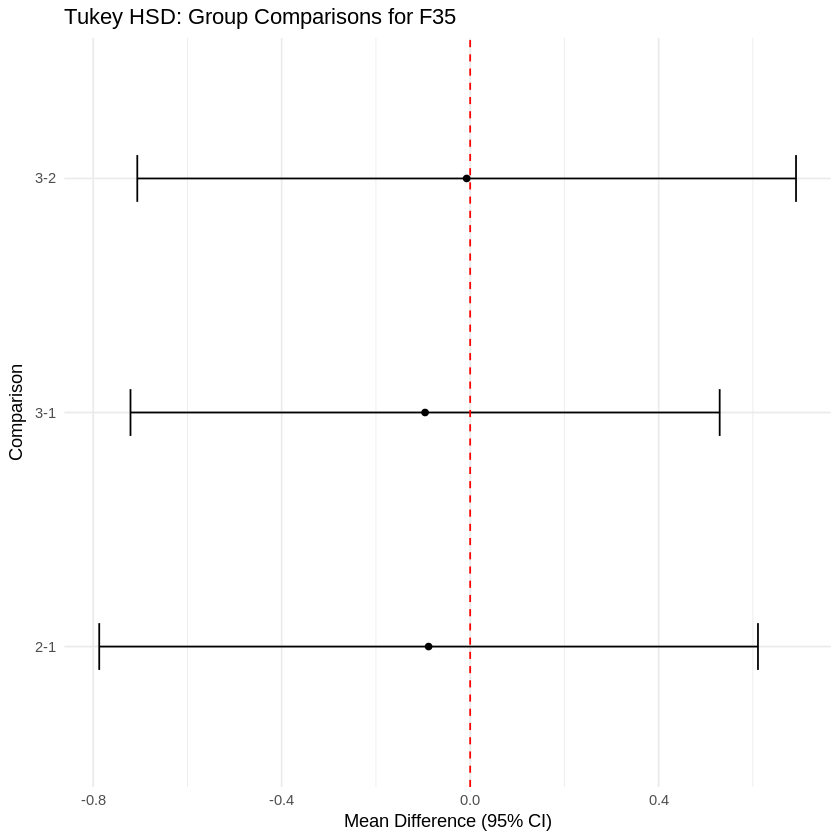

In [9]:
# 9 - Tukey HSD
# Ok let's do post-hoc tests now
# to see which groups are the features different
tukey_df <- TukeyHSD(aov_models[[sig_inx]]) %>%
  broom::tidy()

tukey_df

ggplot(tukey_df, aes(x = contrast,
                     y = estimate)) +
  geom_point() +
  geom_errorbar(aes(ymin = conf.low,
                    ymax = conf.high), width = 0.2) +
  geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
  labs(
    title = "Tukey HSD: Group Comparisons for F35",
    x = "Comparison",
    y = "Mean Difference (95% CI)"
  ) +
  theme_minimal() +
  coord_flip()  # flip for better readability

In the above range plot, we can see that all three confidence intervals cross 0, therefore there are truly no significant pair-wise differences in the mean intensity of F35 between batches 2-1, 3-1, and 3-2.


### Biological interpretation and data export

The final typical step of a metabolomics workflow is some type of functional analysis. Installing R packages for these analysis takes considerable time, so for the sake of the tutorial, we will format the data so it is ready to be uploaded to web-based portals. We recommend using [MetaboAnalyst](https://www.metaboanalyst.ca/MetaboAnalyst/ModuleView.xhtml):

**1 - Functional Analysis module:** functional interpretation of untargeted metabolomics data using the Mummichog algorithm

**2 - Pathway or Enrichment Analysis modules:** functional interpretation of annotated metabolomics data

Follow the steps below if you would like to save the output to your Google Drive so you can upload them to MetaboAnalyst.

In [14]:
# 10 - set up google drive
library(googledrive)

# Authenticate and mount Drive
drive_auth()

# Create a folder to save files to
drive_mkdir("2025 Colab Notebooks")
save_folder <- drive_get("2025 Colab Notebooks")

The googledrive package is requesting access to your Google account.
Enter '1' to start a new auth process or select a pre-authorized account.
1: Send me to the browser for a new auth process.
2: jasminesychong@gmail.com


In [12]:
# 11 - untargeted pathway analysis
# let's get the ms2 annotations for these features
# set up annotation file

annot_data <- csv_list$hilic_pos_annotations_df

aov_res_annot <- aov_res %>%
  tibble::rownames_to_column("id") %>%
  dplyr::left_join(., annot_data)

# 1. for untargeted data
# requires all features and the mz and p-value in the table
aov_res_mum <- aov_res_annot %>%
  select(mz, P.value) %>%
  rename(m.z = mz) %>%
  rename(p.value = P.value) %>%
  filter(!is.na(m.z))

aov_res_mum %>% head()

# save as csv
write.csv(aov_res_mum, "upload_to_metabo_mum.csv", row.names = FALSE)

# upload to google drive
drive_upload("upload_to_metabo_mum.csv", path = as_id(save_folder$id))

Joining with `by = join_by(id)`


,m.z,p.value
,<dbl>,<dbl>
1,141.0659,0.001589297
2,141.0716,0.001687087
3,84.0444,0.034708372
4,84.0444,0.034954044
5,84.0639,0.049882106
6,217.0821,0.119100277


Local file:

• upload_to_metabo_mum.csv

Uploaded into Drive file:

• upload_to_metabo_mum.csv <id: 1xsGq6ObnK6u5X7ZZZS46K7U3pkyOiUVT>

With MIME type:

• text/csv



In [13]:
# 12 - annotated data for pathway/enrichment analysis
# 2. for annotated data
# filter to features with a raw p-value <= 0.15 (NOT KOSHER)
aov_res_sig <- aov_res_annot %>%
  dplyr::filter(P.value <= 0.15) %>%
  select(id, name) %>%
  filter(!is.na(name))

aov_res_sig %>% head()

# save as csv
write.csv(aov_res_sig, "upload_to_metabo_path.csv", row.names = FALSE)

# upload to google drive
drive_upload("upload_to_metabo_path.csv", path = as_id(save_folder$id))

,id,name
,<chr>,<chr>
1,F35,"1,3-Dimethyluracil"
2,F52,L-Valine
3,F255,Oxazine
4,F256,Oxazine
5,F325,Fomepizole
6,F451,4-Hydroxy-2-butenoic acid gamma-lactone


Local file:

• upload_to_metabo_path.csv

Uploaded into Drive file:

• upload_to_metabo_path.csv <id: 1ssTmLARA-YoQIOjiGdu5EWZC3TIK8lpJ>

With MIME type:

• text/csv



To perform functional enrichment or pathway analysis on MetaboAnalyst, please refer to the [tutorials](https://www.metaboanalyst.ca/docs/Tutorials.xhtml), or Chapter X from the first edition of this book for further instruction.

Congratulations! You have just completed a full metabolomic data analysis workflow - you are now on your way to becoming a data science pro.